<a href="https://colab.research.google.com/github/fastai-energetic-engineering/ashrae/blob/master/ASHRAE_energy_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASHRAE Energy Prediction

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [fastai, kaggle]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: false


In [1]:
#collapse
!pip install -Uqq fastbook dtreeviz
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 61kB 3.2MB/s 


In [46]:
import os
import gc
import pandas as pd
import datetime as dt
from tqdm.auto import tqdm
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
tqdm.pandas(desc="apply progress")

# Load ASHRAE energy dataset as parquet from google drive
%cd 'gdrive/MyDrive/Colab Notebooks/ashrae_parquet'
train_valid = pd.read_parquet("train_combined.parquet.snappy")

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


/content/gdrive/.shortcut-targets-by-id/1yStoxel7q5iZ4Xrus1diWNC6aTSUKqkC/ashrae


In [4]:
train_valid.head()

,building_id,meter,timestamp,meter_reading,...,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,...,<NA>,1019.7,0,0.0
1,1,0,2016-01-01,0.0,...,<NA>,1019.7,0,0.0
2,2,0,2016-01-01,0.0,...,<NA>,1019.7,0,0.0
3,3,0,2016-01-01,0.0,...,<NA>,1019.7,0,0.0
4,4,0,2016-01-01,0.0,...,<NA>,1019.7,0,0.0


In [5]:
#train.describe()
train_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20125605 entries, 0 to 20125604
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         Int64         
 1   meter               Int64         
 2   timestamp           datetime64[ns]
 3   meter_reading       float64       
 4   site_id             Int64         
 5   primary_use         string        
 6   square_feet         Int64         
 7   year_built          Int64         
 8   floor_count         Int64         
 9   air_temperature     float64       
 10  cloud_coverage      Int64         
 11  dew_temperature     float64       
 12  precip_depth_1_hr   Int64         
 13  sea_level_pressure  float64       
 14  wind_direction      Int64         
 15  wind_speed          float64       
dtypes: Int64(9), datetime64[ns](1), float64(5), string(1)
memory usage: 2.7 GB


In [6]:
# Engineer some features
year_fraction = train_valid["timestamp"] - train_valid["timestamp"].iloc[0]
train_valid["year_fraction"] = year_fraction / year_fraction.max()
train_valid["week_fraction"] = train_valid["timestamp"].progress_apply(lambda ts: (ts - pd.Timestamp((ts - pd.Timedelta(days=ts.dayofweek)).date())) / pd.Timedelta(days=7))
train_valid["day_fraction"] = train_valid["timestamp"].progress_apply(lambda ts: (ts - pd.Timestamp(ts.date())) / pd.Timedelta(hours=24))

# Save or load the feature engineered dataframe here
%cd 'gdrive/MyDrive/Colab Notebooks/ashrae'
train_valid.to_parquet("feature_enhanced_train_combined.parquet.snappy")
# train_valid = pd.read_parquet("feature_enhanced_train_combined.parquet.snappy")

gc.collect()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-6ee6c1c65d16>", line 8, in <module>
    train_valid.to_parquet("feature_enhanced_train_combined.parquet.snappy")
  File "/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py", line 199, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py", line 2372, in to_parquet
    **kwargs,
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parquet.py", line 276, in to_parquet
    **kwargs,
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parquet.py", line 123, in write
    self.api.parquet.write_table(table, path, compression=compression, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/pyarrow/parquet.py", line 1797, in write_table
    **kwargs) as writer:
  File "/usr/local/lib/python3.7

OSError: ignored

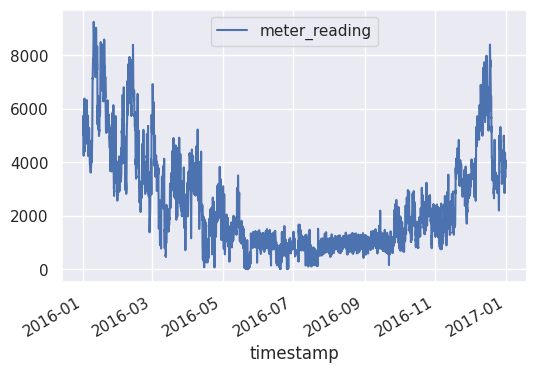

In [7]:
# Get a subset of the data, just one building and meter

train = train_valid[(train_valid['building_id']==1126) & (train_valid['meter']==2)]
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['figure.dpi'] = 100
sns.set()
#%matplotlib inlinefig, axes = plt.subplots(9,2,figsize=(14, 36), dpi=100)
train[['timestamp', 'meter_reading']].set_index('timestamp').plot()


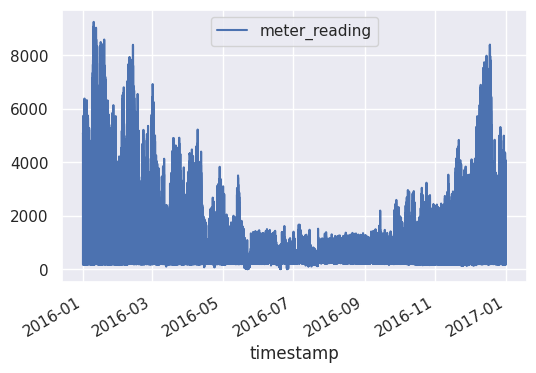

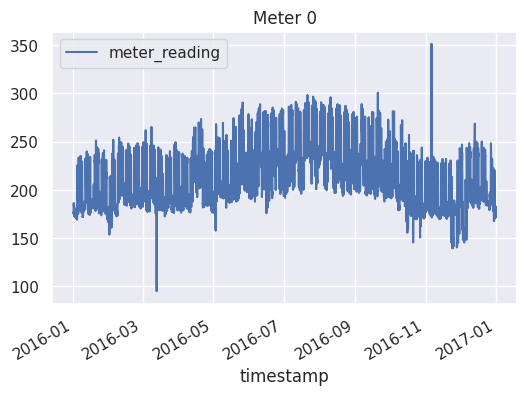

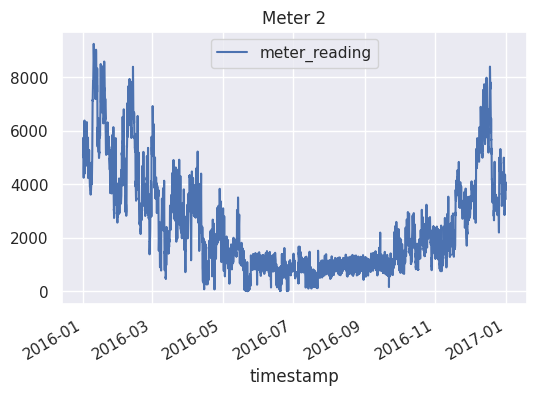

In [8]:
# Get a subset of the data, just one building (all meters)

train = train_valid[(train_valid['building_id']==1126)]
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['figure.dpi'] = 100
sns.set()
#%matplotlib inlinefig, axes = plt.subplots(9,2,figsize=(14, 36), dpi=100)
train[['timestamp', 'meter_reading']].set_index('timestamp').plot()
for i in train['meter'].unique():
    train[train['meter']==i][['timestamp', 'meter_reading']].set_index('timestamp').plot()
    plt.title('Meter ' + str(i))
    # Show/save figure as desired.
    #plt.show()

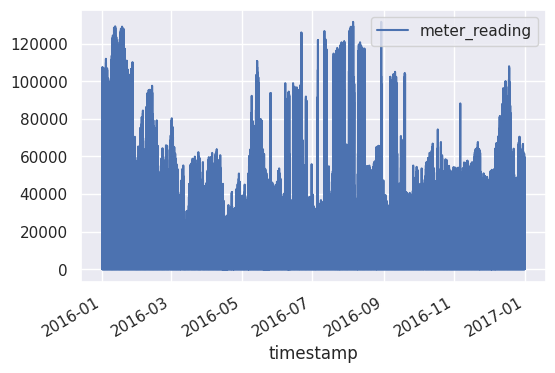

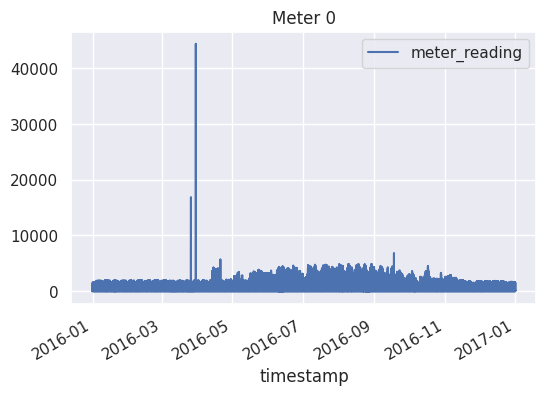

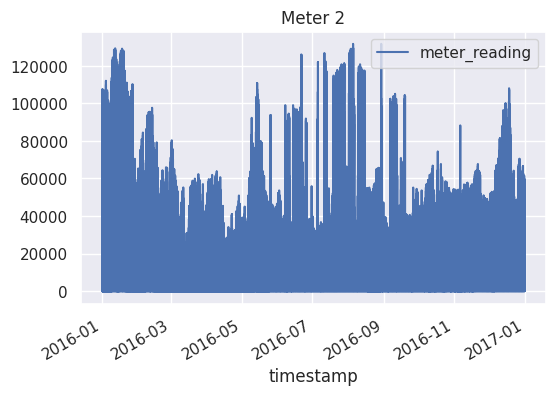

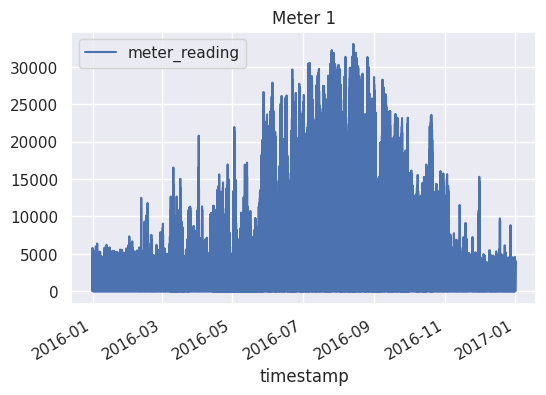

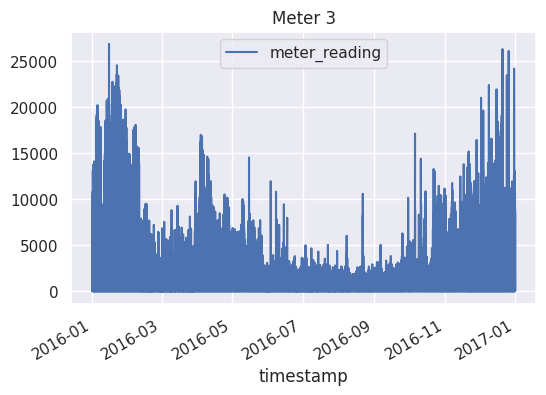

In [ ]:
# Get a subset of the data, a few buildings and all meters

train = train_valid[(train_valid['building_id']>=1126)]

In [38]:
# Use an splitter and load using TabularPandas then to a dataloader

# Drop rows with any column N/A, rather than FillMissing
#train = train[['timestamp', 'building_id', 'meter_reading', 'meter', 'air_temperature', 'dew_temperature']].dropna()

# 2-fold cross-validation. Build 2 models, each with half the year as training data
splits1=MaskSplitter(train['timestamp'] >= '2016-07-01')(range_of(train))
cat_names = ['building_id', 'meter', 'site_id', 'primary_use']
#cont_names = ['timestamp', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'time_diff', 'timestamp_gmt']
cont_names = ['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
cont_names = ['air_temperature', 'dew_temperature']
#cont,cat = cont_cat_split(train, 1, dep_var=dep_var)
procs = [Categorify, FillMissing, Normalize]
to1 = TabularPandas(train, procs=procs,
                   cat_names = cat_names,
                   cont_names = cont_names, 
                   y_names='meter_reading',
                   splits=splits1)
dls1 = to1.dataloaders(bs=1024)

Notes on choice of parameters in block above:
* Using .dropna() on the input dataset before TabularPandas() is slightly better than using FillMissing.
* Normalize doesn't do much.
* The hour feature doesn't do much. Change to Owen's continuous minute feature instead.




In [ ]:
#@title
# Load the entire dataset into a TabularDataLoader

cat_names = ['building_id', 'meter', 'site_id', 'primary_use']
#cont_names = ['timestamp', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'time_diff', 'timestamp_gmt']
cont_names = ['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
procs = [Categorify, FillMissing, Normalize]
dls = TabularDataLoaders.from_df(train.head(64*64), procs=procs, cat_names=cat_names, cont_names=cont_names, 
                                 y_names="meter_reading")

In [ ]:
#@title
# Load a smaller dataset into a TabularDataLoader

t = train[['meter_reading','building_id','meter','air_temperature']]
from fastai.tabular.all import *
cat_names = ['building_id','meter']
cont_names = ['air_temperature']
procs = [Categorify, FillMissing, Normalize]
dls = TabularDataLoaders.from_df(t.head(64*1000), procs=procs, cat_names=cat_names, cont_names=cont_names, 
                                 y_names="meter_reading")

In [39]:
dls1.show_batch()

,building_id,meter,site_id,primary_use,air_temperature_na,dew_temperature_na,air_temperature,dew_temperature,meter_reading
0,1126,0,13,Education,False,False,1.100000,-3.300000,229.248001
1,1126,0,13,Education,False,False,-3.300000,-8.899999,236.016998
2,1126,2,13,Education,False,False,7.800000,-10.000000,2418.949951
3,1126,0,13,Education,False,False,27.200001,20.000000,231.285004
4,1126,2,13,Education,False,False,10.600000,5.600000,1249.020020
5,1126,2,13,Education,False,False,-2.200000,-6.100000,3288.090088
6,1126,2,13,Education,False,False,-12.200000,-22.800000,6959.959961
7,1126,0,13,Education,False,False,-5.600000,-8.300000,171.850006
8,1126,2,13,Education,False,False,25.600000,8.900000,320.312012
9,1126,2,13,Education,False,False,25.600000,7.800000,464.843994


In [ ]:
del train_valid
del train
gc.collect()

In [42]:
# Train a tabular model

learn = tabular_learner(dls1, metrics=rmse)
learn.summary()
# Exploring the learning rates
#learn.lr_find(stop_div=False)
learn.fit_one_cycle(10, lr_max=.2)

epoch,train_loss,valid_loss,_rmse,time
0,6188919.000000,3066236.250000,1751.067261,00:00
1,5963097.000000,3412837.750000,1847.386719,00:00
2,4966474.000000,4524341.500000,2127.050049,00:00
3,3536402.250000,4057199.250000,2014.248901,00:00
4,2676734.750000,717606.437500,847.116516,00:00
5,2073758.375000,495849.031250,704.165466,00:00
6,1651111.500000,333899.781250,577.840637,00:00
7,1344215.625000,171113.109375,413.658203,00:00
8,1111122.750000,110462.679688,332.359253,00:00
9,930869.000000,91555.593750,302.581543,00:00


,building_id,meter,site_id,primary_use,air_temperature_na,dew_temperature_na,air_temperature,dew_temperature,meter_reading,meter_reading_pred
0,1.0,1.0,1.0,1.0,1.0,1.0,0.672019,1.062414,202.442001,125.962082
1,1.0,1.0,1.0,1.0,1.0,1.0,-1.278833,-1.210463,187.841003,112.420059
2,1.0,2.0,1.0,1.0,1.0,1.0,0.035339,0.084332,2457.030029,2212.398438
3,1.0,2.0,1.0,1.0,1.0,1.0,-2.821557,-2.821970,7966.799805,8494.855469
4,1.0,2.0,1.0,1.0,1.0,1.0,-0.503390,-0.129915,3136.719971,3542.648682
5,1.0,2.0,1.0,1.0,1.0,1.0,0.125127,0.391729,1576.170044,1987.776855
6,1.0,2.0,1.0,1.0,1.0,1.0,1.847427,1.164880,1322.270020,358.982819
7,1.0,1.0,1.0,1.0,1.0,1.0,-0.462577,0.028441,185.490997,114.384499
8,1.0,2.0,1.0,1.0,1.0,1.0,1.757639,1.686523,667.968994,428.501221


Training set R2: 0.9626154038777844 RMSE: 379.46884
Validation set R2: 0.9608157461326582 RMSE: 302.58154


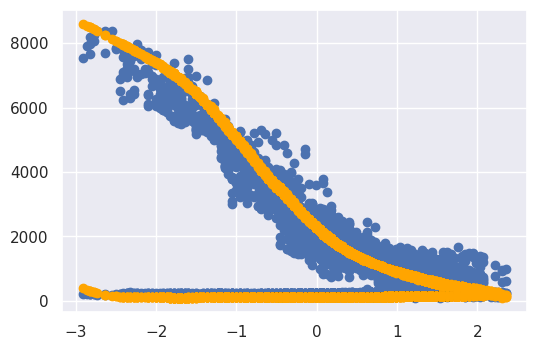

In [43]:
learn.show_results()
from sklearn.metrics import mean_squared_error, r2_score

xs,y = to1.train.xs,to1.train.y
valid_xs,valid_y = to1.valid.xs,to1.valid.y

y_pred,y_targs = learn.get_preds(ds_idx=0)
valid_y_pred,valid_y_targs = learn.get_preds()

print("Training set R2: " + str(r2_score(y_pred.detach().numpy(), y)) + " RMSE: " + str(mean_squared_error(y_pred.detach().numpy(), y, squared=False)))
print("Validation set R2: " + str(r2_score(valid_y_pred.detach().numpy(), valid_y)) + " RMSE: " + str(mean_squared_error(valid_y_pred.detach().numpy(), valid_y, squared=False)))

plt.scatter(valid_xs['air_temperature'], valid_y)
plt.scatter(valid_xs['air_temperature'], valid_y_pred.detach().numpy(), color='orange')

In [ ]:
y_targs.shape

torch.Size([4410, 1])

In [53]:
# Train a fast.ai decision tree
xs,y = to1.train.xs,to1.train.y
valid_xs,valid_y = to1.valid.xs,to1.valid.y
m = DecisionTreeRegressor(min_samples_leaf=100)
m.fit(xs, y);

In [48]:
plot_tree(m, xs, size=10, leaves_parallel=True, precision=2)

NameError: ignored

In [54]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, 'meter_reading',
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [55]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
6,air_temperature,0.530696
1,meter,0.468690
7,dew_temperature,0.000615
0,building_id,0.000000
2,site_id,0.000000
3,primary_use,0.000000
4,air_temperature_na,0.000000
5,dew_temperature_na,0.000000


In [56]:
cluster_columns(xs)

NameError: ignored

Training set R2: 0.8810366827535325 RMSE: 535.787
Validation set R2: 0.848515958335037 RMSE: 797.66364
Coefficients: [-76.61646    9.858627 -53.293335]
Intercept: 3165.656


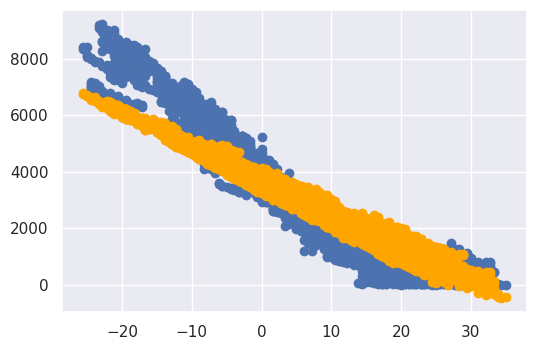

In [ ]:
# Linear regression using scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

xs,y = to1.train.xs,to1.train.y
valid_xs,valid_y = to1.valid.xs,to1.valid.y
m = LinearRegression()
m.fit(xs.to_numpy(), y);
print("Training set R2: " + str(m.score(xs, y)) + " RMSE: " + str(mean_squared_error(y, m.predict(xs), squared=False)))
print("Validation set R2: " + str(m.score(valid_xs, valid_y)) + " RMSE: " + str(mean_squared_error(valid_y, m.predict(valid_xs), squared=False)))
print("Coefficients: " + str(m.coef_))
print("Intercept: " + str(m.intercept_))

#plt.scatter(xs['air_temperature'],y)
plt.scatter(valid_xs['air_temperature'], valid_y)
plt.scatter(valid_xs['air_temperature'], m.predict(valid_xs),color='orange')

Note that the scattered orange line above is due to multiple input variables yet we're just plotting against air_temperature. When just using one input variable, the line is straight.

Parameter containing:
tensor([[-0.0279, -0.2112, -0.4328]], requires_grad=True)
Parameter containing:
tensor([0.3425], requires_grad=True)
tensor(6083564.5000, grad_fn=<MseLossBackward>)
Training loss:  tensor(3157270.2500, grad_fn=<MseLossBackward>)
Training loss:  tensor(3038562.2500, grad_fn=<MseLossBackward>)
Training loss:  tensor(3040172.5000, grad_fn=<MseLossBackward>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Using a target size (torch.Size([4410])) that is different to the input size (torch.Size([4410, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Using a target size (torch.Size([58])) that is different to the input size (torch.Size([58, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Using a target size (torch.Size([4410])) that is different to the input size (tor

Training loss:  tensor(3001640., grad_fn=<MseLossBackward>)
Training loss:  tensor(2953377.5000, grad_fn=<MseLossBackward>)
Training loss:  tensor(2978136.2500, grad_fn=<MseLossBackward>)
Training loss:  tensor(2934418.5000, grad_fn=<MseLossBackward>)
Training loss:  tensor(2877487.5000, grad_fn=<MseLossBackward>)
Training loss:  tensor(2840216., grad_fn=<MseLossBackward>)
Training loss:  tensor(2837932.2500, grad_fn=<MseLossBackward>)
Training loss:  tensor(2799506.5000, grad_fn=<MseLossBackward>)
Training loss:  tensor(2836210.5000, grad_fn=<MseLossBackward>)
Training loss:  tensor(2776785.7500, grad_fn=<MseLossBackward>)
Training loss:  tensor(2802382., grad_fn=<MseLossBackward>)
Training loss:  tensor(2742863., grad_fn=<MseLossBackward>)
Training loss:  tensor(2720460.7500, grad_fn=<MseLossBackward>)
Training loss:  tensor(2746403.7500, grad_fn=<MseLossBackward>)
Training loss:  tensor(2706342.2500, grad_fn=<MseLossBackward>)
Training loss:  tensor(2714497.5000, grad_fn=<MseLossBac

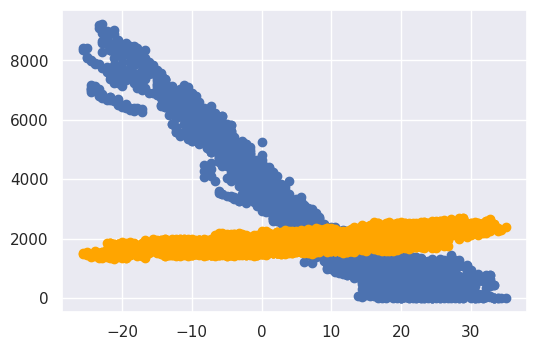

In [ ]:
# Linear regression using PyTorch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score

xs,y = torch.tensor(to1.train.xs.values),torch.tensor(to1.train.y.values)
valid_xs,valid_y = torch.tensor(to1.valid.xs.values),torch.tensor(to1.valid.y.values)

# Define dataset
train_ds = TensorDataset(xs, y)
#train_ds = TensorDataset(torch.tensor(xs.values), torch.tensor(y.values))
#train_ds = Dataset.from_tensor_slices((xs, y))
print(train_ds)

# Define data loader
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
next(iter(train_dl))

# Define model
model = nn.Linear(xs.shape[1], 1)#y.shape[1])
print(model.weight)
print(model.bias)

# Define optimizer
opt = torch.optim.SGD(model.parameters(), lr=.001)

# Define loss function
import torch.nn.functional as F
loss_fn = F.mse_loss
loss = loss_fn(model(xs), y)
print(loss)

def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            # Generate predictions
            pred = model(xb)
            loss = loss_fn(pred, yb)
            # Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
        print('Training loss: ', loss_fn(model(xs), y))

# Train the model for several epochs
fit(50, model, loss_fn, opt)

# Generate predictions
y_pred = model(xs)
valid_y_pred = model(valid_xs)
print("Training set R2: " + str(r2_score(y_pred.detach().numpy(), y)) + " RMSE: " + str(mean_squared_error(y_pred.detach().numpy(), y, squared=False)))
print("Validation set R2: " + str(r2_score(valid_y_pred.detach().numpy(), valid_y)) + " RMSE: " + str(mean_squared_error(valid_y_pred.detach().numpy(), valid_y, squared=False)))
print("Coefficients: " + str(model.weight))
print("Intercept" + str(model.bias))

plt.scatter(valid_xs[:,0], valid_y)
plt.scatter(valid_xs[:,0], valid_y_pred.detach().numpy(), color='orange')

To do:


1.   Figure out why continuous variables are shown as boolean
2.   Handle dates
3.   Create training and validation sets, rather than using TabularDataLoader

